32:
150
180


In [821]:
layer = 32
filter = 180

In [822]:
octave_n = 12
octave_scale = 1.2

In [823]:
%matplotlib inline

In [824]:
from fastai.conv_learner import *
from scipy import ndimage

In [825]:
from cv2 import resize

In [826]:
torch.backends.cudnn.benchmark = True

In [827]:
model = vgg16(pre=True).cuda().eval()
set_trainable(model, False)

In [828]:
class SaveFeatures():
    features = None
    def __init__(self, module):
        self.hook = module.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output):
        self.features = torch.tensor(output,requires_grad=True).cuda()
    def close(self):
        self.hook.remove()

In [829]:
feat = SaveFeatures(list(model.children())[layer])

In [830]:
sz = 56

In [831]:
img = np.uint8(np.random.uniform(150, 180, (sz, sz, 3)))/255

In [832]:
for oct in range(octave_n):
    train_tfms, val_tfms = tfms_from_model(vgg16, sz)
    img_var = V(val_tfms(img)[None], requires_grad=True)
    optimizer = torch.optim.Adam([img_var], lr=0.1, weight_decay=1e-6)
    for n in range(20):
        optimizer.zero_grad()
        model(img_var)
        loss = -feat.features[0, filter].mean()
        loss.backward()
#        if n%10 == 0: print(loss.item())
        optimizer.step()
    
#    img_var.data.sub_(img_var.data.mean())
#    img_var.data.div_(img_var.data.std())

    
    img = val_tfms.denorm(img_var.data.cpu().numpy()[0].transpose(1,2,0))
    img_save = img
    sz = int(octave_scale * sz)
    img = cv2.resize(img, (sz, sz), interpolation = cv2.INTER_CUBIC)
    img = cv2.blur(img,(5,5))
    
    
    

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


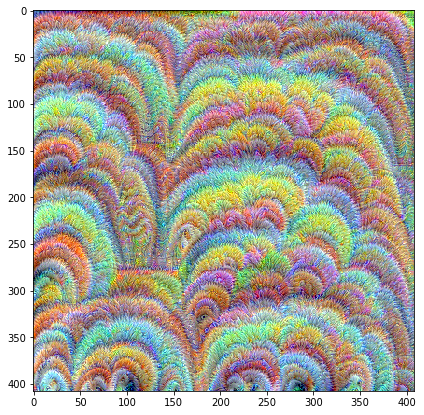

In [833]:
plt.figure(figsize=(7,7))
plt.imshow(img_save)

In [834]:
img_save.shape

(408, 408, 3)

In [835]:
feat.close()

In [836]:
img_save.min()

-0.5885025